In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as dts
import netCDF4 as nc
import os
import re
import pytz
import csv
import time

%matplotlib inline

In [3]:
def loadSOGHoff(fname):
    data2=dict()
    with open(fname, 'rt') as file_obj:
        for index, line in enumerate(file_obj):
            line = line.strip()
            if line.startswith('*FieldNames:'):
                field_names = line.split(': ', 1)[1].split(', ')
            elif line.startswith('*FieldUnits:'):
                field_units = line.split(': ', 1)[1].split(', ')
            elif line.startswith('*HoffmuellerStartYr:'):
                year_start = line.split(': ', 1)[1]
            elif line.startswith('*HoffmuellerStartDay:'):
                day_start = line.split(': ', 1)[1]
            elif line.startswith('*HoffmuellerStartSec:'):
                sec_start = line.split(': ', 1)[1]
            elif line.startswith('*HoffmuellerInterval:'):
                 interval = line.split(': ', 1)[1]
            elif line.startswith('*EndOfHeader'):
                break
    # Timestamp in matplotlib time
    dt_start = dts.date2num(dt.datetime.strptime(year_start + ' ' + day_start, '%Y %j')) + float(sec_start)/86400
    
    data = pd.read_csv(fname, delim_whitespace=True, header=0, names=field_names, skiprows=index, chunksize=82)
    # Extract dataframe chunks into dictionary
    times=list()
    for index, chunk in enumerate(data):
        times.append(dts.num2date(dt_start + index*float(interval), tz=pytz.timezone('UTC')))
        if index==0:
            da=chunk
        else:
            da=np.dstack((da,chunk))
    data2['times']=np.array(times)
    for iel in range(0,len(field_names)):
        data2[field_names[iel]]=da[:,iel,:].transpose()
        
    return data2

In [4]:
d=dict()
d['orig']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/HCa/profiles/hoff-SOG.dat')
d['a']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/A01/profiles/hoff-SOG.dat')
d['b']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/A02a/profiles/hoff-SOG.dat')
d['c']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/A02b/profiles/hoff-SOG.dat')
d['d']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/A02c/profiles/hoff-SOG.dat')
d['e']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/Z3_e/profiles/hoff-SOG.dat')
d['f']=loadSOGHoff('/data/eolson/SOG/SOG-runs/exp/Z3_f/profiles/hoff-SOG.dat')

In [5]:
d.keys()

dict_keys(['a', 'f', 'orig', 'e', 'b', 'c', 'd'])

In [6]:
#d['Q9'].keys()

In [7]:
style={'micro phytoplankton':'-','nano phytoplankton':'--','pico phytoplankton':'.-',
       'nitrate':'-o','silicon':'->','ammonium':'-x','micro zooplankton':'+'}
col={'orig':'k','a':'goldenrod','b':'blueviolet','c':'deeppink','d':'dodgerblue','e':'aqua'}
     #'R1':'dodgerblue','A3':'lime','N3':'m','A5':'pink','C2':'gold','A6':'brown',
     #'F1':'blue','C4':'turquoise','C5':'mediumseagreen','C6':'red','C7':'c','C8':'pink',
     #'M1':'darkorange','R5':'purple','M3':'darkorange','M5':'limegreen','M6':'firebrick',
     #'M7':'darkkhaki','N2':'aquamarine','M8':'peru','R2':'deeppink','R3':'darkkhaki','Si3':'orange'}

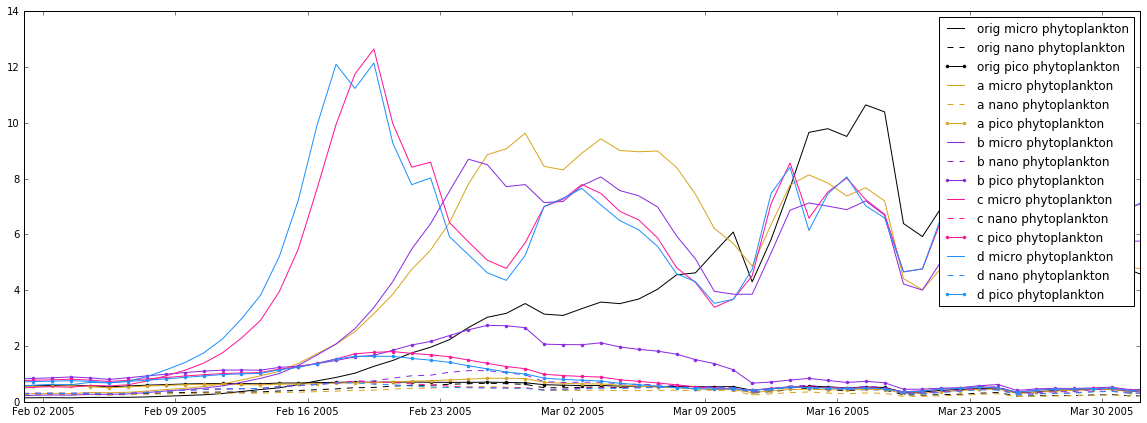

In [9]:
fig, axs = plt.subplots(1,1,figsize=(20,7))
for el in ('orig','a','b','c','d'):#,'b','f',):#,'HCi'):
    for var in ('micro phytoplankton','nano phytoplankton','pico phytoplankton'):
        axs.plot(d[el]['times'],np.mean(d[el][var][:,0:6],1),style[var],color=col[el],label=el+' '+var)
axs.set_xlim(dt.datetime(2005,2,1),dt.datetime(2005,4,1))#dt.datetime(2005,11,1))
axs.legend(loc=1)

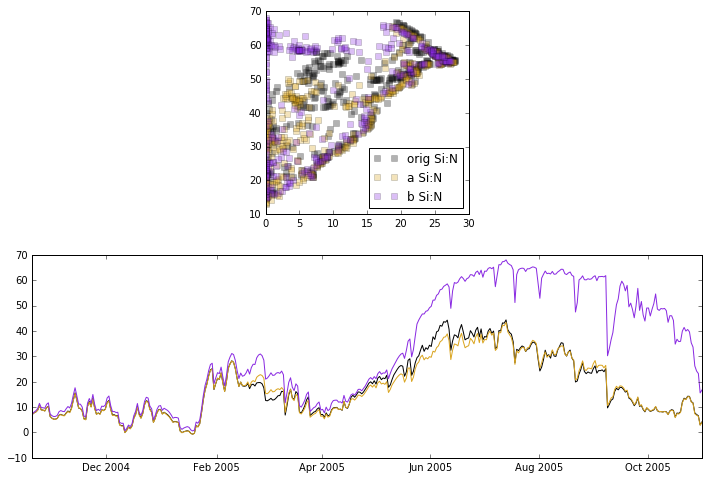

In [8]:
fig, axs = plt.subplots(2,1,figsize=(12,8))
for el in ('orig','a','b'):
    axs[0].plot(np.mean(d[el]['nitrate'][:,0:6],1),np.mean(d[el]['silicon'][:,0:6],1),'s',alpha=.3,color=col[el],label=el+' Si:N')
    #ts=d[el]['times']
    #xs=np.mean(d[el]['silicon'][:,0:6]+.002,1)/np.mean(d[el]['nitrate'][:,0:6]+.001,1)
    #ys=np.mean(d[el]['nitrate'][:,0:6]+.001,1)
    #axs.plot(ts[ys>1],xs[ys>1],'s',color=col[el],label=el+' Si:N')
    axs[1].plot(d[el]['times'],np.mean(d[el]['silicon'][:,0:6],1)-2*np.mean(d[el]['nitrate'][:,0:6],1),color=col[el])
#axs.set_xlim(dt.datetime(2005,2,1),dt.datetime(2005,10,1))
axs[0].legend(loc=4)
axs[0].set_aspect(.5)

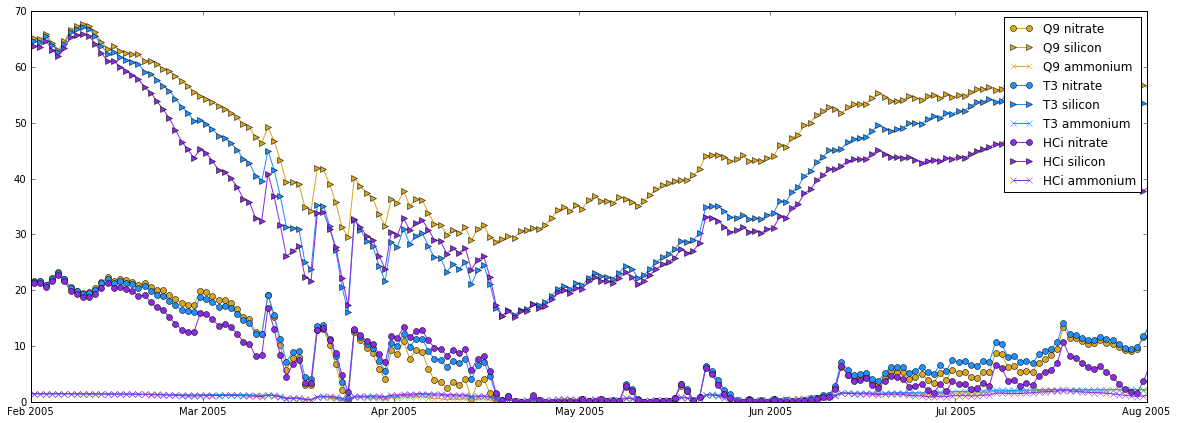

In [21]:
fig, axs = plt.subplots(1,1,figsize=(20,7))
for el in ('Q9','T3','HCi'):
    for var in ('nitrate','silicon','ammonium'):
        axs.plot(d[el]['times'],np.mean(d[el][var][:,0:6],1),style[var],color=col[el],label=el+' '+var)
axs.set_xlim(dt.datetime(2005,2,1),dt.datetime(2005,8,1))
axs.legend(loc=1)

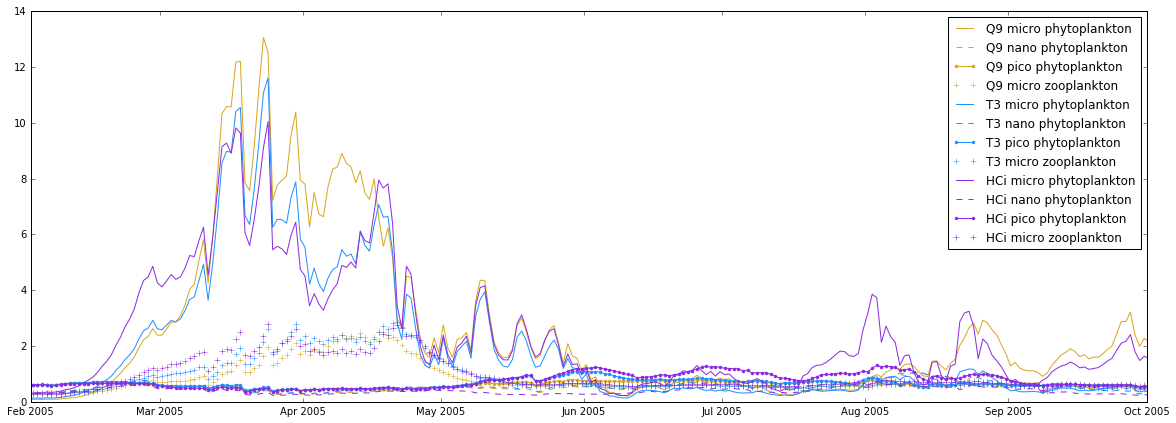

In [22]:

fig, axs = plt.subplots(1,1,figsize=(20,7))
for el in ('Q9','T3','HCi'):
    for var in ('micro phytoplankton','nano phytoplankton','pico phytoplankton','micro zooplankton'):
        axs.plot(d[el]['times'],np.mean(d[el][var][:,0:6],1),style[var],color=col[el],label=el+' '+var)

#axs.plot(d['M5']['times'],np.mean(d['M5']['micro phytoplankton'][:,0:6],1),'g*')
axs.set_xlim(dt.datetime(2005,2,1),dt.datetime(2005,10,1))
axs.legend(loc=1)
# axs.plot(d['C5']['times'][128],10,'rs')

In [ ]:

fig, axs = plt.subplots(1,1,figsize=(20,7))
for el in ('orig','Q9','HC2','HC1'):
    for var in ('pico phytoplankton',):
        axs.plot(d[el]['times'],np.mean(d[el][var][:,0:6],1),style[var],color=col[el],label=el+' '+var)

#axs.plot(d['M5']['times'],np.mean(d['M5']['micro phytoplankton'][:,0:6],1),'g*')
axs.set_xlim(dt.datetime(2005,2,1),dt.datetime(2005,10,1))
axs.legend(loc=1)
# axs.plot(d['C5']['times'][128],10,'rs')